<h1>Import necessary libraries</h1>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
from PIL import Image
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 25 13:54:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Configure tensorflow to only use the gpu (Run this only when you want to train on GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("using GPU")
    except RuntimeError as e:
        print(e)

using GPU


<h1>Load dataset</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/data/', 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1)) 

Found 19520 files belonging to 1 classes.


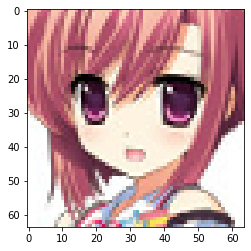

In [ ]:
plt.imshow(plt.imread('/content/drive/My Drive/data/1.png'))

<h1>Define Generator and Discriminator</h1>

In [ ]:
# Weights initializer
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [ ]:
def build_generator(seed_size):

    generator = Sequential()
  
    # Block - 1
    generator.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    generator.add(BatchNormalization())
    generator.add(ReLU())
    generator.add(Reshape((4,4,1024))) # Resulting shape = (4,4,1024) 

    # Block - 2
    generator.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(ReLU())  # Resulting shape = (8,8,512)

    # Block - 3
    generator.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(ReLU()) # Resulting shape = (16,16,256)

    # Block - 4
    generator.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(BatchNormalization())
    generator.add(ReLU()) # Resulting shape = (32,32,128)

    # Block - 5
    generator.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    generator.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return generator

In [ ]:
def build_discriminator(image_length,image_channels):
    
    discriminator = Sequential()
  
    # Block - 1
    discriminator.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    # Block - 2
    discriminator.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    # Block - 3
    discriminator.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    # Block - 4
    discriminator.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    # Block - 5
    discriminator.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    discriminator.add(Flatten())
    discriminator.add(Activation('sigmoid'))

    return discriminator

<h1>Define Keras Model</h1>

One-sided-label smoothing has been implemented (only for discriminator) to prevent the discriminator from overpowering the generator. Specifying this parameter changes the labels for real images from `1` to `(1-smooth)`. 

`smooth` parameter defined in the `discriminator_loss()` function takes care of this

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
class DCGAN(keras.Model):
    
    def __init__(self,seed_size,image_length,image_channels,**kwargs):

        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size

        
           
    def generator_loss(self,fake_output):        
        return cross_entropy(tf.ones_like(fake_output), fake_output)

       
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):

        batch_size = tf.shape(data)[0]
        
        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            # generate image using generator
            generated_image = self.generator(seed, training = True)
        
            # discriminator's prediction for real image
            real_output = self.discriminator(data,training = True)
            
            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image,training = True) 
            
            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            # optimize generator 
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            # optimize discriminator 
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# parameters and hyperparameters
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16

#fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))

### Initialize the DCGAN

In [ ]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
          noise = tf.random.normal([10,seed_size])
          image = dcgan.generator(noise)
          plt.imshow(image[0].numpy().reshape(64,64,3)*0.5+0.5)
          plt.show()

<h1>Training</h1>

In [ ]:
tf.config.run_functions_eagerly(True)

Epoch 1/120
153/153 [==============================] - ETA: 0s - generator loss: 8.0597 - discriminator_loss: 1.4253

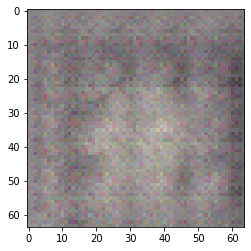

153/153 [==============================] - 261s 44ms/step - generator loss: 8.0239 - discriminator_loss: 1.4206
Epoch 2/120
153/153 [==============================] - ETA: 0s - generator loss: 2.3115 - discriminator_loss: 1.0428

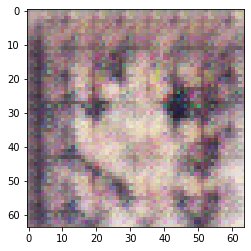

153/153 [==============================] - 7s 44ms/step - generator loss: 2.3116 - discriminator_loss: 1.0410
Epoch 3/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.1265 - discriminator_loss: 0.9475

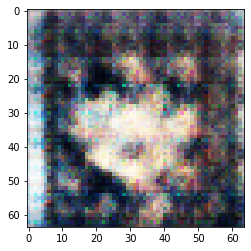

153/153 [==============================] - 7s 44ms/step - generator loss: 2.1376 - discriminator_loss: 0.9457
Epoch 4/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.1083 - discriminator_loss: 1.0347

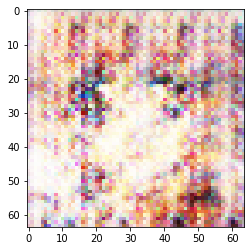

153/153 [==============================] - 7s 44ms/step - generator loss: 2.1117 - discriminator_loss: 1.0361
Epoch 5/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.0084 - discriminator_loss: 1.0652

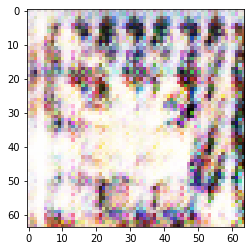

153/153 [==============================] - 7s 44ms/step - generator loss: 2.0171 - discriminator_loss: 1.0616
Epoch 6/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.0193 - discriminator_loss: 1.0685

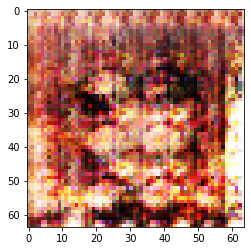

153/153 [==============================] - 7s 44ms/step - generator loss: 2.0319 - discriminator_loss: 1.0672
Epoch 7/120
151/153 [============================>.] - ETA: 0s - generator loss: 1.9680 - discriminator_loss: 1.0197

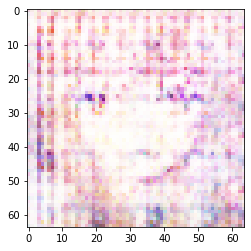

153/153 [==============================] - 7s 44ms/step - generator loss: 1.9701 - discriminator_loss: 1.0155
Epoch 8/120
152/153 [============================>.] - ETA: 0s - generator loss: 1.9903 - discriminator_loss: 1.0125

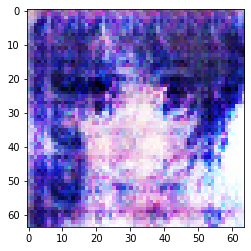

153/153 [==============================] - 7s 45ms/step - generator loss: 1.9793 - discriminator_loss: 1.0106
Epoch 9/120
152/153 [============================>.] - ETA: 0s - generator loss: 1.9416 - discriminator_loss: 1.0246

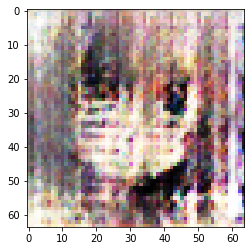

153/153 [==============================] - 7s 44ms/step - generator loss: 1.9328 - discriminator_loss: 1.0241
Epoch 10/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.0979 - discriminator_loss: 0.9935

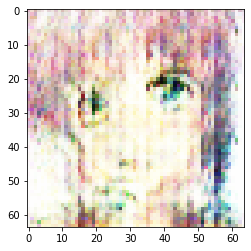

153/153 [==============================] - 7s 44ms/step - generator loss: 2.0907 - discriminator_loss: 0.9920
Epoch 11/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.0572 - discriminator_loss: 0.8787

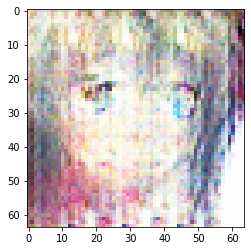

153/153 [==============================] - 7s 44ms/step - generator loss: 2.0562 - discriminator_loss: 0.8754
Epoch 12/120
153/153 [==============================] - ETA: 0s - generator loss: 2.2520 - discriminator_loss: 0.8588

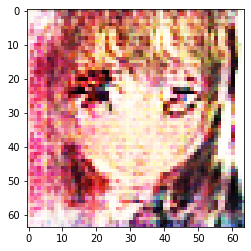

153/153 [==============================] - 7s 44ms/step - generator loss: 2.2555 - discriminator_loss: 0.8578
Epoch 13/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.3494 - discriminator_loss: 0.8652

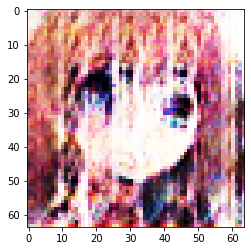

153/153 [==============================] - 7s 44ms/step - generator loss: 2.3867 - discriminator_loss: 0.8722
Epoch 14/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.5375 - discriminator_loss: 0.8261

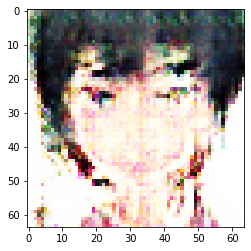

153/153 [==============================] - 7s 44ms/step - generator loss: 2.5153 - discriminator_loss: 0.8293
Epoch 15/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.4037 - discriminator_loss: 0.7810

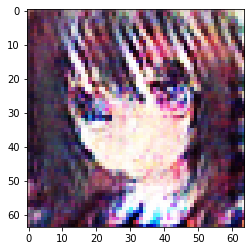

153/153 [==============================] - 7s 44ms/step - generator loss: 2.4002 - discriminator_loss: 0.7799
Epoch 16/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.5024 - discriminator_loss: 0.7416

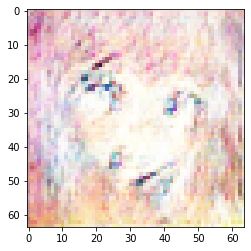

153/153 [==============================] - 7s 44ms/step - generator loss: 2.4932 - discriminator_loss: 0.7403
Epoch 17/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.6188 - discriminator_loss: 0.7628

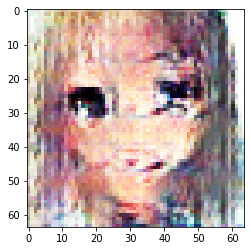

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6190 - discriminator_loss: 0.7633
Epoch 18/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.5838 - discriminator_loss: 0.8019

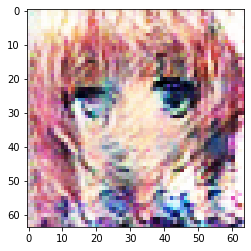

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6421 - discriminator_loss: 0.8156
Epoch 19/120
153/153 [==============================] - ETA: 0s - generator loss: 2.5647 - discriminator_loss: 0.7703

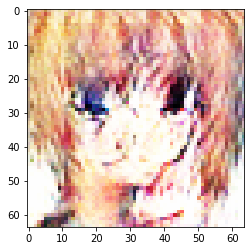

153/153 [==============================] - 7s 44ms/step - generator loss: 2.5592 - discriminator_loss: 0.7698
Epoch 20/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.5651 - discriminator_loss: 0.7856

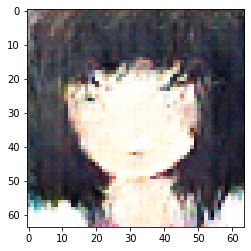

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6087 - discriminator_loss: 0.7877
Epoch 21/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.4910 - discriminator_loss: 0.7409

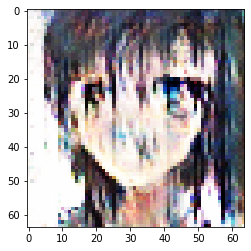

153/153 [==============================] - 7s 44ms/step - generator loss: 2.4714 - discriminator_loss: 0.7454
Epoch 22/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.6337 - discriminator_loss: 0.8030

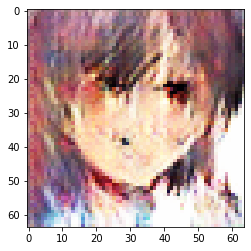

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6237 - discriminator_loss: 0.8005
Epoch 23/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.5275 - discriminator_loss: 0.7715

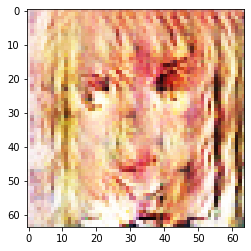

153/153 [==============================] - 7s 44ms/step - generator loss: 2.5208 - discriminator_loss: 0.7706
Epoch 24/120
153/153 [==============================] - ETA: 0s - generator loss: 2.4684 - discriminator_loss: 0.7469

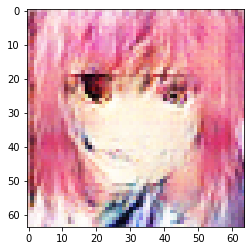

153/153 [==============================] - 7s 44ms/step - generator loss: 2.4894 - discriminator_loss: 0.7503
Epoch 25/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.6313 - discriminator_loss: 0.7259

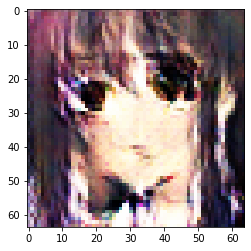

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6194 - discriminator_loss: 0.7255
Epoch 26/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.5692 - discriminator_loss: 0.7081

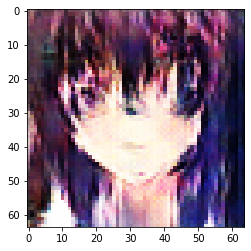

153/153 [==============================] - 7s 44ms/step - generator loss: 2.5629 - discriminator_loss: 0.7063
Epoch 27/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.6357 - discriminator_loss: 0.7311

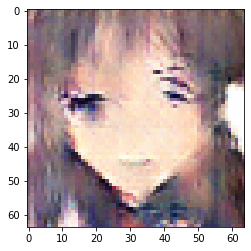

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6214 - discriminator_loss: 0.7385
Epoch 28/120
153/153 [==============================] - ETA: 0s - generator loss: 2.6129 - discriminator_loss: 0.7540

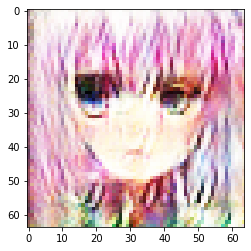

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6086 - discriminator_loss: 0.7533
Epoch 29/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.6534 - discriminator_loss: 0.7168

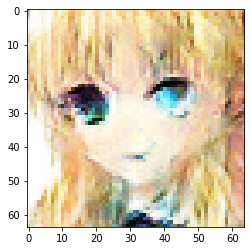

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6470 - discriminator_loss: 0.7155
Epoch 30/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.6693 - discriminator_loss: 0.7299

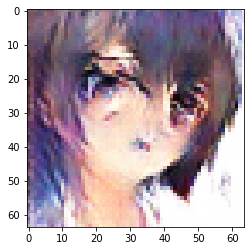

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6514 - discriminator_loss: 0.7308
Epoch 31/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.6369 - discriminator_loss: 0.7280

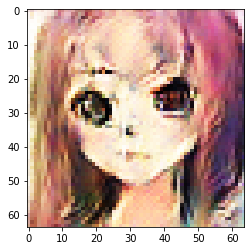

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6528 - discriminator_loss: 0.7335
Epoch 32/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.6267 - discriminator_loss: 0.7091

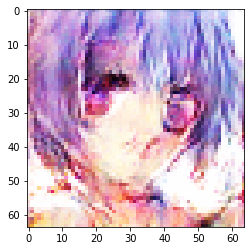

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6350 - discriminator_loss: 0.7117
Epoch 33/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7179 - discriminator_loss: 0.7180

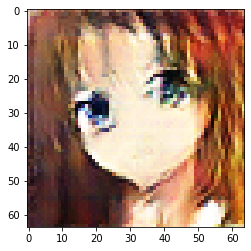

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7282 - discriminator_loss: 0.7183
Epoch 34/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.7003 - discriminator_loss: 0.6765

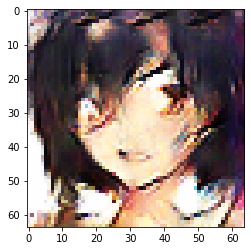

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6888 - discriminator_loss: 0.6813
Epoch 35/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.7117 - discriminator_loss: 0.7109

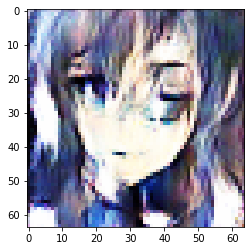

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7151 - discriminator_loss: 0.7076
Epoch 36/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7041 - discriminator_loss: 0.6668

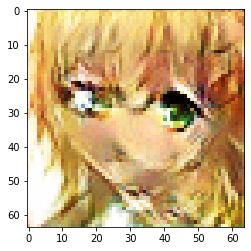

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6921 - discriminator_loss: 0.6668
Epoch 37/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.7745 - discriminator_loss: 0.6822

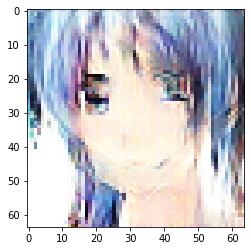

153/153 [==============================] - 7s 45ms/step - generator loss: 2.7714 - discriminator_loss: 0.6910
Epoch 38/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.4802 - discriminator_loss: 0.8560

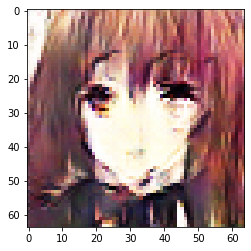

153/153 [==============================] - 7s 44ms/step - generator loss: 2.4823 - discriminator_loss: 0.8587
Epoch 39/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.6905 - discriminator_loss: 0.6621

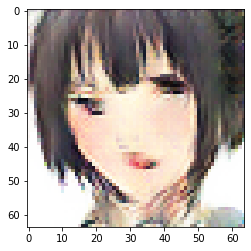

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6916 - discriminator_loss: 0.6612
Epoch 40/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7357 - discriminator_loss: 0.6775

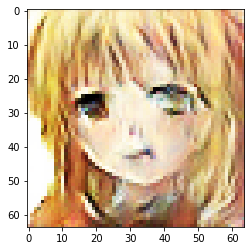

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7976 - discriminator_loss: 0.6879
Epoch 41/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7247 - discriminator_loss: 0.6808

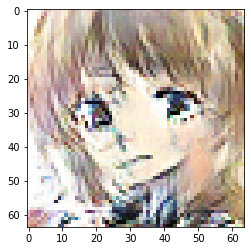

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7152 - discriminator_loss: 0.6805
Epoch 42/120
153/153 [==============================] - ETA: 0s - generator loss: 2.7208 - discriminator_loss: 0.7322

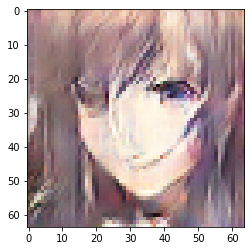

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7181 - discriminator_loss: 0.7312
Epoch 43/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7232 - discriminator_loss: 0.6468

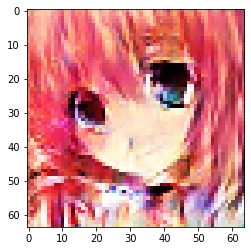

153/153 [==============================] - 7s 45ms/step - generator loss: 2.7331 - discriminator_loss: 0.6466
Epoch 44/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.7737 - discriminator_loss: 0.6806

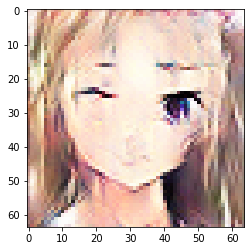

153/153 [==============================] - 7s 45ms/step - generator loss: 2.7743 - discriminator_loss: 0.6809
Epoch 45/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.8230 - discriminator_loss: 0.6803

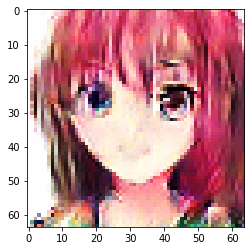

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8162 - discriminator_loss: 0.6783
Epoch 46/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7738 - discriminator_loss: 0.6553

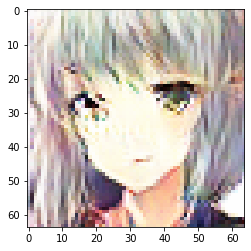

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7640 - discriminator_loss: 0.6541
Epoch 47/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.8864 - discriminator_loss: 0.6301

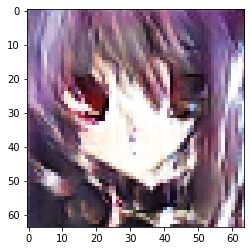

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8809 - discriminator_loss: 0.6286
Epoch 48/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9082 - discriminator_loss: 0.7536

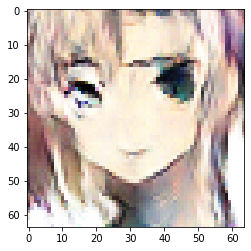

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8938 - discriminator_loss: 0.7519
Epoch 49/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.6987 - discriminator_loss: 0.6502

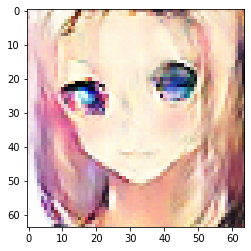

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6967 - discriminator_loss: 0.6475
Epoch 50/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.8049 - discriminator_loss: 0.6236

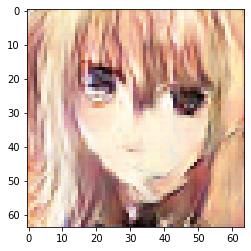

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8099 - discriminator_loss: 0.6216
Epoch 51/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.8613 - discriminator_loss: 0.6472

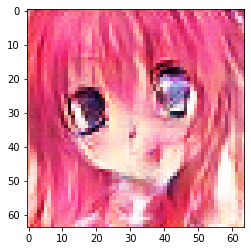

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8606 - discriminator_loss: 0.6463
Epoch 52/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.8678 - discriminator_loss: 0.6641

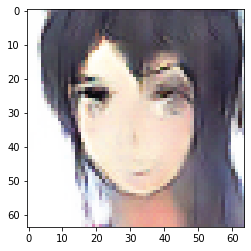

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8626 - discriminator_loss: 0.7034
Epoch 53/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.7757 - discriminator_loss: 0.6736

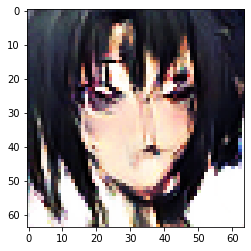

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7883 - discriminator_loss: 0.6751
Epoch 54/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7860 - discriminator_loss: 0.6389

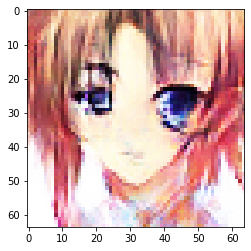

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7862 - discriminator_loss: 0.6372
Epoch 55/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.8770 - discriminator_loss: 0.6448

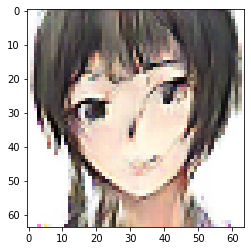

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8742 - discriminator_loss: 0.6439
Epoch 56/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.8828 - discriminator_loss: 0.6147

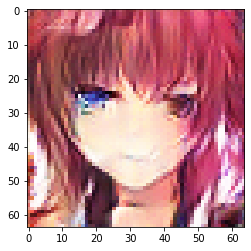

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8775 - discriminator_loss: 0.6135
Epoch 57/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9102 - discriminator_loss: 0.6635

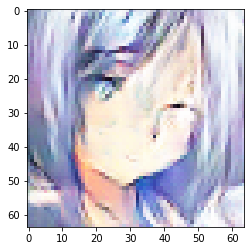

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9129 - discriminator_loss: 0.6622
Epoch 58/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9008 - discriminator_loss: 0.6097

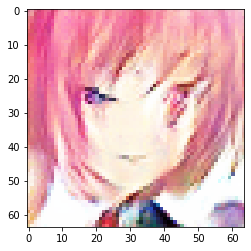

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9158 - discriminator_loss: 0.6119
Epoch 59/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9621 - discriminator_loss: 0.6059

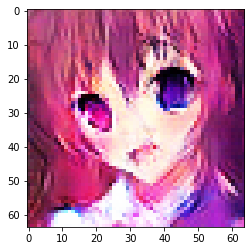

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9581 - discriminator_loss: 0.6084
Epoch 60/120
153/153 [==============================] - ETA: 0s - generator loss: 2.8379 - discriminator_loss: 0.7140

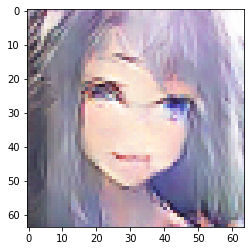

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8336 - discriminator_loss: 0.7129
Epoch 61/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.8759 - discriminator_loss: 0.5891

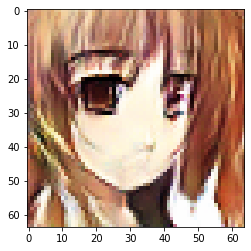

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8713 - discriminator_loss: 0.5880
Epoch 62/120
153/153 [==============================] - ETA: 0s - generator loss: 2.8825 - discriminator_loss: 0.8615

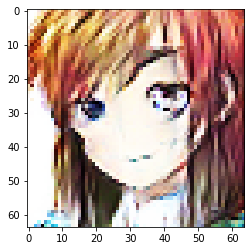

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8867 - discriminator_loss: 0.8591
Epoch 63/120
153/153 [==============================] - ETA: 0s - generator loss: 2.6894 - discriminator_loss: 0.5722

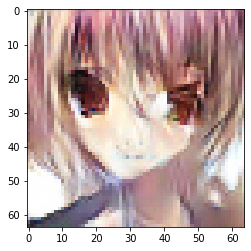

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6796 - discriminator_loss: 0.5742
Epoch 64/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.8947 - discriminator_loss: 0.5807

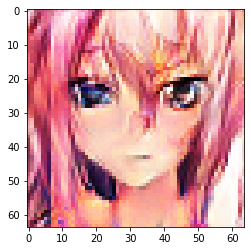

153/153 [==============================] - 7s 44ms/step - generator loss: 2.8731 - discriminator_loss: 0.5842
Epoch 65/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9719 - discriminator_loss: 0.5973

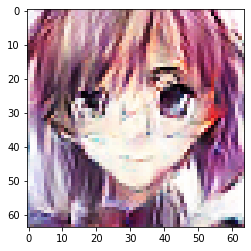

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9845 - discriminator_loss: 0.6003
Epoch 66/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9912 - discriminator_loss: 0.6077

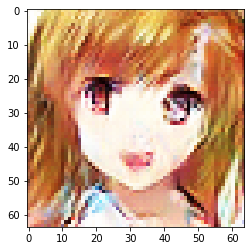

153/153 [==============================] - 7s 44ms/step - generator loss: 3.0245 - discriminator_loss: 0.6098
Epoch 67/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9211 - discriminator_loss: 0.5879

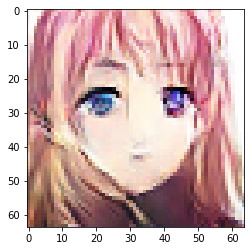

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9189 - discriminator_loss: 0.5858
Epoch 68/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9993 - discriminator_loss: 0.6089

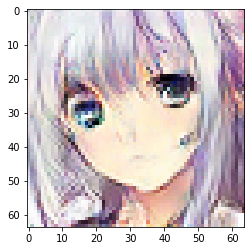

153/153 [==============================] - 7s 44ms/step - generator loss: 3.0088 - discriminator_loss: 0.6066
Epoch 69/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9739 - discriminator_loss: 0.7304

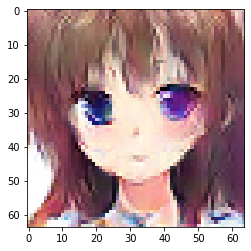

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9664 - discriminator_loss: 0.7254
Epoch 70/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9357 - discriminator_loss: 0.5453

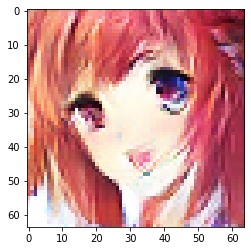

153/153 [==============================] - 7s 45ms/step - generator loss: 2.9413 - discriminator_loss: 0.5446
Epoch 71/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.1174 - discriminator_loss: 0.6967

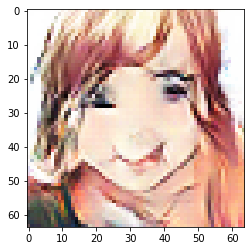

153/153 [==============================] - 7s 45ms/step - generator loss: 3.1352 - discriminator_loss: 0.7338
Epoch 72/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7055 - discriminator_loss: 0.6121

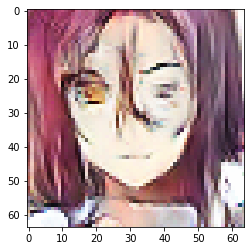

153/153 [==============================] - 7s 44ms/step - generator loss: 2.6907 - discriminator_loss: 0.6132
Epoch 73/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9789 - discriminator_loss: 0.5687

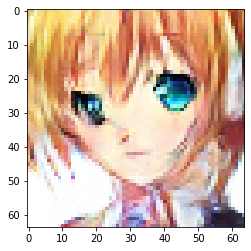

153/153 [==============================] - 7s 45ms/step - generator loss: 2.9758 - discriminator_loss: 0.5673
Epoch 74/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.9849 - discriminator_loss: 0.6171

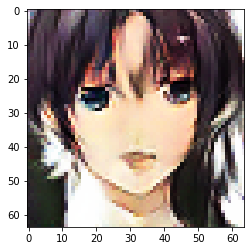

153/153 [==============================] - 8s 47ms/step - generator loss: 2.9801 - discriminator_loss: 0.6145
Epoch 75/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.0741 - discriminator_loss: 0.5456

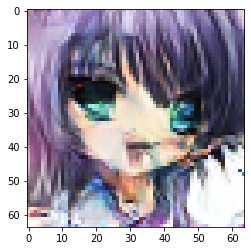

153/153 [==============================] - 7s 44ms/step - generator loss: 3.0879 - discriminator_loss: 0.5444
Epoch 76/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.0918 - discriminator_loss: 0.5564

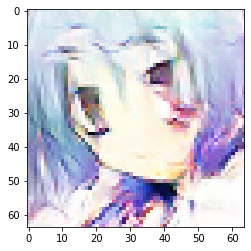

153/153 [==============================] - 7s 44ms/step - generator loss: 3.0940 - discriminator_loss: 0.5545
Epoch 77/120
153/153 [==============================] - ETA: 0s - generator loss: 3.1303 - discriminator_loss: 0.5395

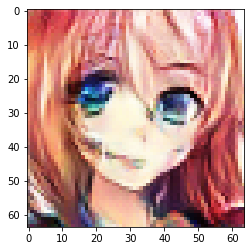

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1279 - discriminator_loss: 0.5390
Epoch 78/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.7225 - discriminator_loss: 0.9192

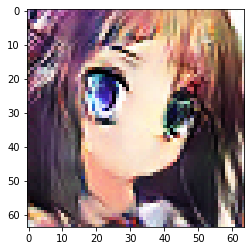

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7299 - discriminator_loss: 0.9109
Epoch 79/120
153/153 [==============================] - ETA: 0s - generator loss: 2.9845 - discriminator_loss: 0.5413

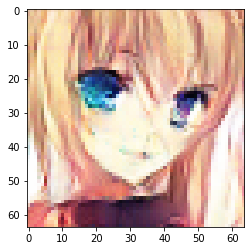

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9781 - discriminator_loss: 0.5414
Epoch 80/120
153/153 [==============================] - ETA: 0s - generator loss: 3.0884 - discriminator_loss: 0.5383

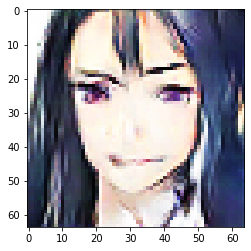

153/153 [==============================] - 7s 44ms/step - generator loss: 3.0975 - discriminator_loss: 0.5390
Epoch 81/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.1252 - discriminator_loss: 0.5486

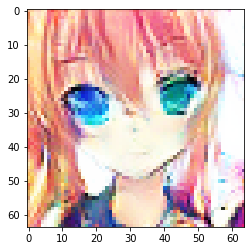

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1596 - discriminator_loss: 0.5546
Epoch 82/120
153/153 [==============================] - ETA: 0s - generator loss: 3.1710 - discriminator_loss: 0.5386

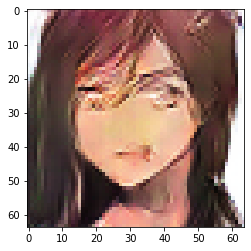

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1622 - discriminator_loss: 0.5391
Epoch 83/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.7567 - discriminator_loss: 0.9213

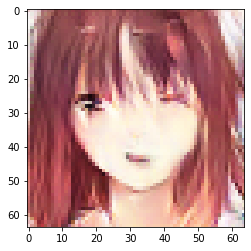

153/153 [==============================] - 7s 44ms/step - generator loss: 2.7578 - discriminator_loss: 0.9155
Epoch 84/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9797 - discriminator_loss: 0.5326

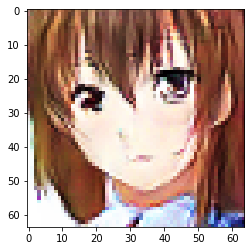

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9710 - discriminator_loss: 0.5322
Epoch 85/120
153/153 [==============================] - ETA: 0s - generator loss: 3.1358 - discriminator_loss: 0.5150

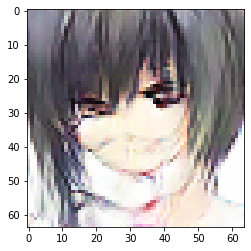

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1436 - discriminator_loss: 0.5152
Epoch 86/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.1888 - discriminator_loss: 0.5234

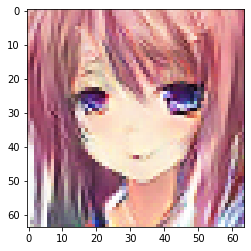

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1986 - discriminator_loss: 0.5246
Epoch 87/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.2547 - discriminator_loss: 0.6164

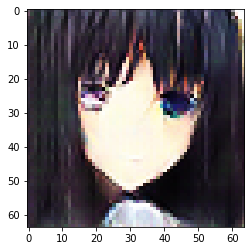

153/153 [==============================] - 7s 45ms/step - generator loss: 3.2495 - discriminator_loss: 0.6214
Epoch 88/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.0980 - discriminator_loss: 0.5144

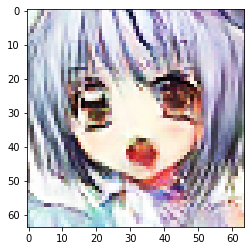

153/153 [==============================] - 7s 45ms/step - generator loss: 3.0939 - discriminator_loss: 0.5137
Epoch 89/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.1878 - discriminator_loss: 0.5578

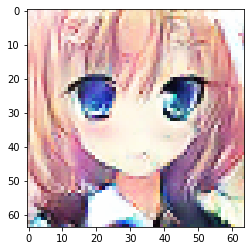

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1937 - discriminator_loss: 0.5562
Epoch 90/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.3341 - discriminator_loss: 0.4760

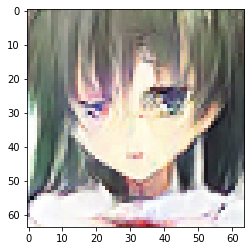

153/153 [==============================] - 7s 44ms/step - generator loss: 3.3263 - discriminator_loss: 0.4759
Epoch 91/120
152/153 [============================>.] - ETA: 0s - generator loss: 2.9906 - discriminator_loss: 1.0107

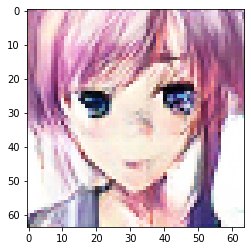

153/153 [==============================] - 7s 44ms/step - generator loss: 2.9793 - discriminator_loss: 1.0104
Epoch 92/120
151/153 [============================>.] - ETA: 0s - generator loss: 2.5221 - discriminator_loss: 0.7949

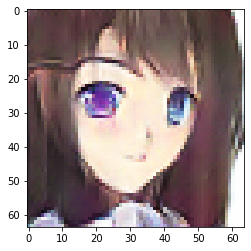

153/153 [==============================] - 7s 44ms/step - generator loss: 2.5304 - discriminator_loss: 0.7888
Epoch 93/120
153/153 [==============================] - ETA: 0s - generator loss: 3.0557 - discriminator_loss: 0.4995

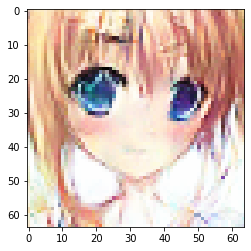

153/153 [==============================] - 7s 45ms/step - generator loss: 3.0523 - discriminator_loss: 0.4993
Epoch 94/120
153/153 [==============================] - ETA: 0s - generator loss: 3.2166 - discriminator_loss: 0.4810

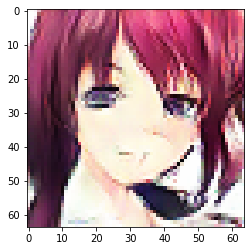

153/153 [==============================] - 7s 44ms/step - generator loss: 3.2028 - discriminator_loss: 0.4842
Epoch 95/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.2288 - discriminator_loss: 0.5417

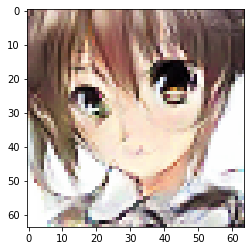

153/153 [==============================] - 7s 44ms/step - generator loss: 3.2389 - discriminator_loss: 0.5398
Epoch 96/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.3153 - discriminator_loss: 0.4897

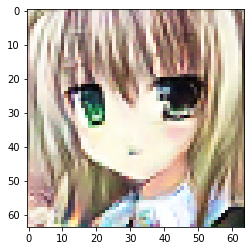

153/153 [==============================] - 7s 44ms/step - generator loss: 3.3141 - discriminator_loss: 0.4887
Epoch 97/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.3625 - discriminator_loss: 0.4773

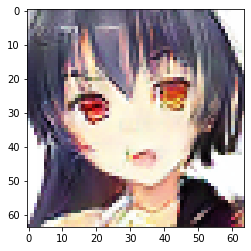

153/153 [==============================] - 7s 44ms/step - generator loss: 3.3512 - discriminator_loss: 0.4774
Epoch 98/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.1896 - discriminator_loss: 0.6422

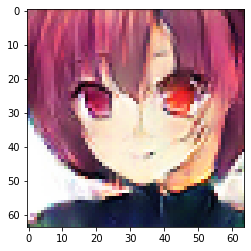

153/153 [==============================] - 7s 44ms/step - generator loss: 3.1942 - discriminator_loss: 0.6390
Epoch 99/120
153/153 [==============================] - ETA: 0s - generator loss: 3.3718 - discriminator_loss: 0.4800

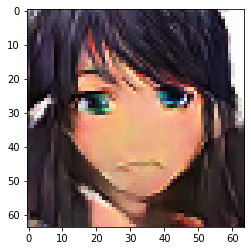

153/153 [==============================] - 7s 44ms/step - generator loss: 3.3725 - discriminator_loss: 0.4794
Epoch 100/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.3301 - discriminator_loss: 0.5499

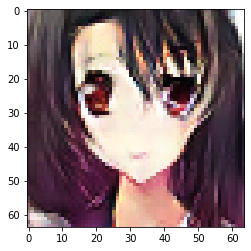

153/153 [==============================] - 7s 44ms/step - generator loss: 3.3361 - discriminator_loss: 0.5480
Epoch 101/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.4700 - discriminator_loss: 0.4766

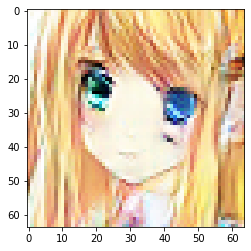

153/153 [==============================] - 7s 45ms/step - generator loss: 3.4676 - discriminator_loss: 0.4764
Epoch 102/120
153/153 [==============================] - ETA: 0s - generator loss: 3.5763 - discriminator_loss: 0.4541

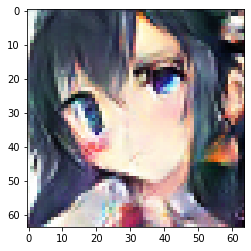

153/153 [==============================] - 7s 44ms/step - generator loss: 3.5821 - discriminator_loss: 0.4536
Epoch 103/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.0622 - discriminator_loss: 0.7471

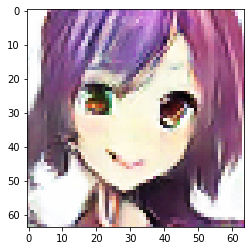

153/153 [==============================] - 7s 44ms/step - generator loss: 3.0744 - discriminator_loss: 0.7432
Epoch 104/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.4524 - discriminator_loss: 0.4600

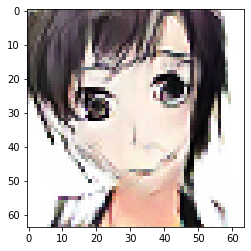

153/153 [==============================] - 7s 45ms/step - generator loss: 3.4582 - discriminator_loss: 0.4599
Epoch 105/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.3629 - discriminator_loss: 0.6408

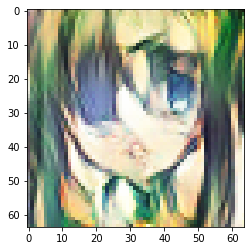

153/153 [==============================] - 7s 45ms/step - generator loss: 3.3551 - discriminator_loss: 0.6373
Epoch 106/120
153/153 [==============================] - ETA: 0s - generator loss: 3.4306 - discriminator_loss: 0.4561

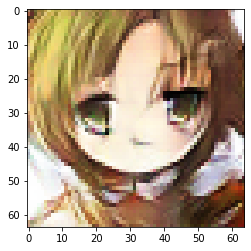

153/153 [==============================] - 7s 45ms/step - generator loss: 3.4280 - discriminator_loss: 0.4561
Epoch 107/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.6484 - discriminator_loss: 0.4246

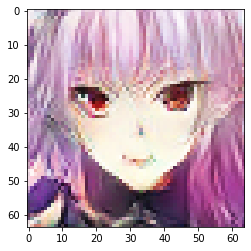

153/153 [==============================] - 7s 45ms/step - generator loss: 3.6544 - discriminator_loss: 0.4244
Epoch 108/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.6019 - discriminator_loss: 0.5234

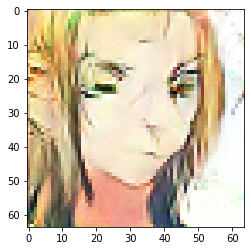

153/153 [==============================] - 7s 45ms/step - generator loss: 3.5936 - discriminator_loss: 0.5230
Epoch 109/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.4771 - discriminator_loss: 0.4950

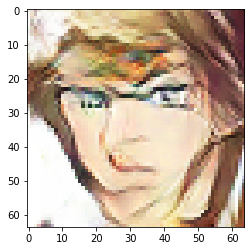

153/153 [==============================] - 7s 44ms/step - generator loss: 3.4840 - discriminator_loss: 0.4935
Epoch 110/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.7181 - discriminator_loss: 0.4251

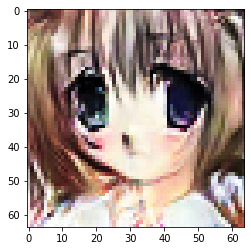

153/153 [==============================] - 7s 45ms/step - generator loss: 3.7335 - discriminator_loss: 0.4250
Epoch 111/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.8240 - discriminator_loss: 0.4226

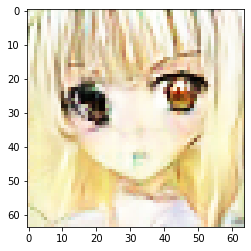

153/153 [==============================] - 7s 46ms/step - generator loss: 3.8296 - discriminator_loss: 0.4224
Epoch 112/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.0659 - discriminator_loss: 0.8233

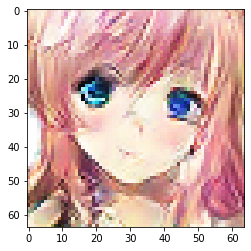

153/153 [==============================] - 7s 45ms/step - generator loss: 3.0725 - discriminator_loss: 0.8181
Epoch 113/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.4985 - discriminator_loss: 0.4586

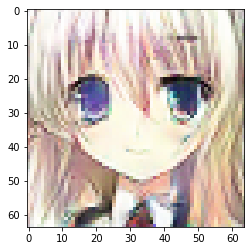

153/153 [==============================] - 7s 45ms/step - generator loss: 3.5065 - discriminator_loss: 0.4574
Epoch 114/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.6069 - discriminator_loss: 0.4824

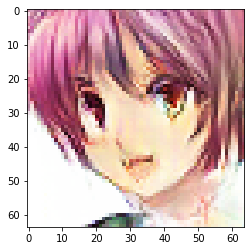

153/153 [==============================] - 7s 45ms/step - generator loss: 3.5943 - discriminator_loss: 0.4826
Epoch 115/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.7964 - discriminator_loss: 0.4125

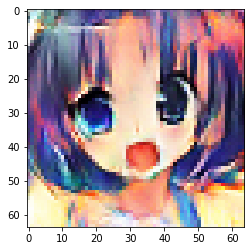

153/153 [==============================] - 7s 45ms/step - generator loss: 3.8117 - discriminator_loss: 0.4126
Epoch 116/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.8706 - discriminator_loss: 0.4203

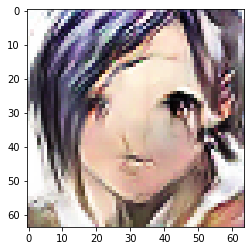

153/153 [==============================] - 7s 45ms/step - generator loss: 3.8768 - discriminator_loss: 0.4200
Epoch 117/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.5513 - discriminator_loss: 0.8075

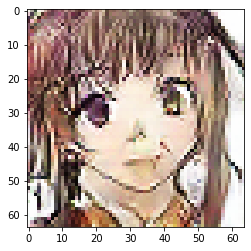

153/153 [==============================] - 7s 45ms/step - generator loss: 3.5508 - discriminator_loss: 0.8113
Epoch 118/120
153/153 [==============================] - ETA: 0s - generator loss: 2.9908 - discriminator_loss: 0.6413

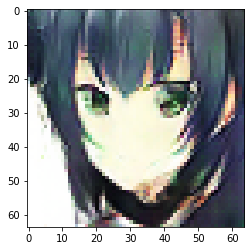

153/153 [==============================] - 7s 45ms/step - generator loss: 2.9975 - discriminator_loss: 0.6401
Epoch 119/120
152/153 [============================>.] - ETA: 0s - generator loss: 3.5684 - discriminator_loss: 0.4297

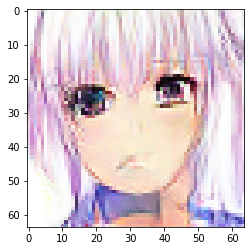

153/153 [==============================] - 7s 45ms/step - generator loss: 3.5679 - discriminator_loss: 0.4291
Epoch 120/120
151/153 [============================>.] - ETA: 0s - generator loss: 3.6515 - discriminator_loss: 0.4600

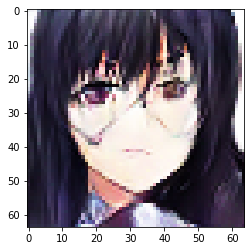

153/153 [==============================] - 7s 45ms/step - generator loss: 3.6574 - discriminator_loss: 0.4587


In [ ]:
with tf.device('GPU'):
  history = dcgan.fit(train_ds,epochs=120,batch_size=batch_size,callbacks=[CustomCallback()])

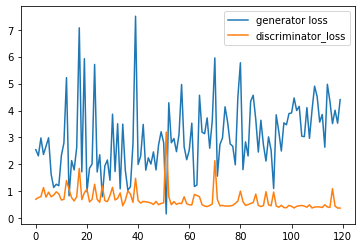

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.legend(pd.DataFrame(history.history))

<h1>Testing</h1>

In [ ]:
def generate_faces():
    """Generates random Anime faces"""
    
    # generate 64 images by giving 64 inputs
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

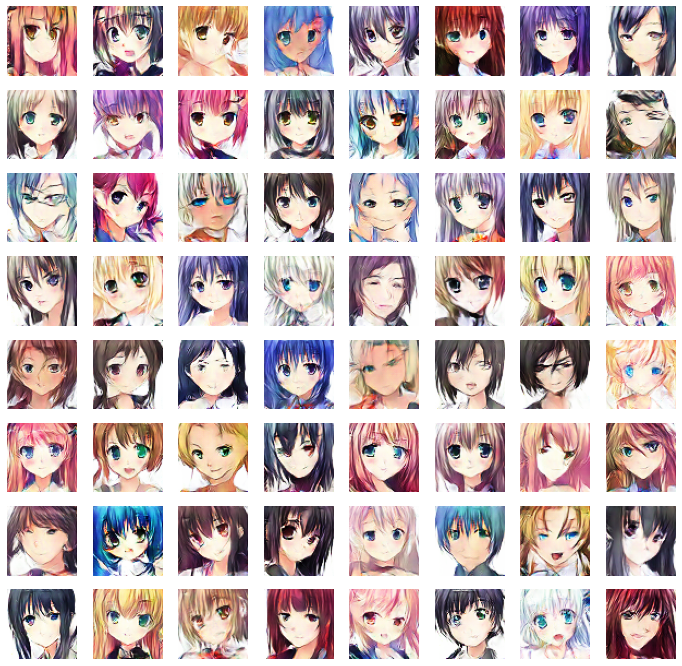

In [ ]:
generate_faces()